In [ ]:

# ────────────── 1) IMPORTS ──────────────
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
# ────────────── 2) PARAMETERS ──────────────
IMG_WIDTH, IMG_HEIGHT = 128, 32
MAX_LABEL_LENGTH = 110

# ────────────── 3) HELPER: RESIZE + PAD ──────────────
def resize_with_padding(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT, upscale=True):
    img = img.convert("L")
    old_w, old_h = img.size
    scale = min(target_width/old_w, target_height/old_h)
    if not upscale:
        scale = min(scale, 1.0)
    new_w, new_h = int(old_w*scale), int(old_h*scale)
    img = img.resize((new_w, new_h), resample=Image.Resampling.LANCZOS)
    canvas = Image.new("L", (target_width, target_height), 255)
    ul = ((target_width-new_w)//2, (target_height-new_h)//2)
    canvas.paste(img, ul)
    return np.expand_dims(np.array(canvas, dtype=np.float32)/255.0, -1)

# ────────────── 4) LOAD & PREPROCESS IAM DATA ──────────────
dataset = load_dataset("Teklia/IAM-line")
iam_texts = [ex["text"] for ex in dataset["train"]]

# build char tokenizer
tokenizer = Tokenizer(char_level=True, lower=False, filters="")
tokenizer.fit_on_texts(iam_texts)
M = max(tokenizer.word_index.values())
NUM_CLASSES = M + 1  # blank token at index M

# preprocess IAM images
train_images = np.array([
    resize_with_padding(ex["image"])
    for ex in dataset["train"]
])

# preprocess IAM labels
train_labels = tokenizer.texts_to_sequences(iam_texts)
train_labels = pad_sequences(train_labels, MAX_LABEL_LENGTH, padding="post", value=0)
train_labels = np.where(train_labels != 0, train_labels - 1, 0)  # map to 0..M-1

print("IAM data:", train_images.shape, train_labels.shape)

# ────────────── 5) LOAD & PREPROCESS CUSTOM DATA ──────────────
samples_image_folder = "/Users/shikhusanjel/Desktop/CNNTEST/jpg"
samples_label_file   = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt"  # YOUR PATH HERE

# read labels
with open(samples_label_file, "r", encoding="utf-8") as f:
    custom_labels = [l.strip() for l in f]

# list & sort images
image_paths = sorted([
    os.path.join(samples_image_folder, f)
    for f in os.listdir(samples_image_folder)
    if f.lower().endswith(".jpg")
])
print("Custom count:", len(image_paths), len(custom_labels))

# preprocess custom images + labels
custom_images = np.array([
    resize_with_padding(Image.open(p))
    for p in image_paths
])
custom_seq = tokenizer.texts_to_sequences(custom_labels)
custom_seq = pad_sequences(custom_seq, MAX_LABEL_LENGTH, padding="post", value=0)
custom_seq = np.where(custom_seq != 0, custom_seq - 1, 0)

print("Custom data:", custom_images.shape, custom_seq.shape)

# ────────────── 6) MERGE & SPLIT ──────────────
X = np.concatenate([train_images, custom_images], axis=0)
Y = np.concatenate([train_labels,  custom_seq   ], axis=0)

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)
print("Split:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# ────────────── 7) BUILD & COMPILE MODEL ──────────────
input_img    = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name="image_input")
labels_input = layers.Input((MAX_LABEL_LENGTH,), dtype="int32", name="label")

# CNN + BiLSTM + CTC
x = layers.Conv2D(64, 3, padding="same", activation="relu")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128,3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Reshape((-1, 128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

def ctc_lambda(args):
    y_pred, labels = args
    # get time dimension, cast to float
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    # build input_length as float32
    input_len = tf.ones((tf.shape(y_pred)[0],1), dtype="float32") * time_steps
    # count nonzero labels, cast to float32
    label_len = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)


loss_out = layers.Lambda(
    ctc_lambda,
    output_shape=(1,),
    name="ctc_loss"
)([y_pred, labels_input])


optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
ctc_model = Model([input_img, labels_input], loss_out)
ctc_model.compile(optimizer=optimizer, loss=lambda y_true,y_pred: y_pred)

# ────────────── 8) TRAIN ──────────────
dummy_train = np.zeros((len(X_train),1))
dummy_val   = np.zeros((len(X_val  ),1))

ctc_model.fit(
    [X_train, y_train], dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20, batch_size=32
)

# ────────────── 9) PREDICTION MODEL & DECODER ──────────────
pred_model = Model(input_img, y_pred)

def decode_batch(preds):
    input_len = np.ones((preds.shape[0],)) * preds.shape[1]
    decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)
    seqs = decoded[0].numpy()
    texts=[]
    for seq in seqs:
        s = "".join([ tokenizer.sequences_to_texts([[t+1]])[0] for t in seq if t>=0 ])
        texts.append(s)
    return texts

# ────────────── 10) RUN ON YOUR TEST FOLDER ──────────────
test_folder = "/Users/shikhusanjel/Desktop/test"  # YOUR PATH HERE
test_paths  = sorted([os.path.join(test_folder,f)
                      for f in os.listdir(test_folder) if f.endswith(".jpg")])

test_images = np.array([resize_with_padding(Image.open(p)) for p in test_paths])
test_preds  = pred_model.predict(test_images)
decoded     = decode_batch(test_preds)

# visualize
for img, txt in zip(test_images, decoded):
    plt.figure(figsize=(6,2))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Predicted: {txt}")
    plt.axis("off")
    plt.show()



In [ ]:
from tensorflow.keras.layers import RandomContrast, RandomZoom
# ────────────── 1) IMPORTS ──────────────
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# ────────────── 2) PARAMETERS ──────────────
IMG_WIDTH, IMG_HEIGHT = 128, 32
MAX_LABEL_LENGTH = 110

import cv2      # ← new, alongside your other imports


def resize_with_padding(img,
                        target_width=IMG_WIDTH,
                        target_height=IMG_HEIGHT,
                        upscale=True):
    # 1) convert to grayscale numpy array
    arr = np.array(img.convert("L"))
    
    # 2) adaptive threshold (Gaussian)
    #    — this binarizes the ink vs. paper
    arr = cv2.adaptiveThreshold(
        arr,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=11,
        C=2
    )
    
    # 3) back to PIL Image so we can reuse your pad/resize logic
    img = Image.fromarray(arr)
    
    # — now the same centering & padding as before —
    old_w, old_h = img.size
    scale = min(target_width/old_w, target_height/old_h)
    if not upscale:
        scale = min(scale, 1.0)
    new_w = int(old_w * scale)
    new_h = int(old_h * scale)
    
    # high-quality resize
    img = img.resize((new_w, new_h), resample=Image.Resampling.LANCZOS)
    
    # create white canvas and paste centered
    canvas = Image.new("L", (target_width, target_height), 255)
    ul = ((target_width-new_w)//2, (target_height-new_h)//2)
    canvas.paste(img, ul)
    
    # normalize and add channel dim
    return np.expand_dims(np.array(canvas, dtype=np.float32)/255.0, axis=-1)



# ────────────── 4) LOAD & PREPROCESS IAM DATA ──────────────
dataset = load_dataset("Teklia/IAM-line")
iam_texts = [ex["text"] for ex in dataset["train"]]

# build char tokenizer
tokenizer = Tokenizer(char_level=True, lower=False, filters="")
tokenizer.fit_on_texts(iam_texts)
M = max(tokenizer.word_index.values())
NUM_CLASSES = M + 1  # blank token at index M

# preprocess IAM images
train_images = np.array([
    resize_with_padding(ex["image"])
    for ex in dataset["train"]
])

# preprocess IAM labels
train_labels = tokenizer.texts_to_sequences(iam_texts)
train_labels = pad_sequences(train_labels, MAX_LABEL_LENGTH, padding="post", value=0)
train_labels = np.where(train_labels != 0, train_labels - 1, 0)  # map to 0..M-1

print("IAM data:", train_images.shape, train_labels.shape)

# ────────────── 5) LOAD & PREPROCESS CUSTOM DATA ──────────────
samples_image_folder = "/Users/shikhusanjel/Desktop/CNNTEST/jpg"
samples_label_file   = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt"  # YOUR PATH HERE

# read labels
with open(samples_label_file, "r", encoding="utf-8") as f:
    custom_labels = [l.strip() for l in f]

# list & sort images
image_paths = sorted([
    os.path.join(samples_image_folder, f)
    for f in os.listdir(samples_image_folder)
    if f.lower().endswith(".jpg")
])
print("Custom count:", len(image_paths), len(custom_labels))

# preprocess custom images + labels
custom_images = np.array([
    resize_with_padding(Image.open(p))
    for p in image_paths
])
custom_seq = tokenizer.texts_to_sequences(custom_labels)
custom_seq = pad_sequences(custom_seq, MAX_LABEL_LENGTH, padding="post", value=0)
custom_seq = np.where(custom_seq != 0, custom_seq - 1, 0)

print("Custom data:", custom_images.shape, custom_seq.shape)

# ────────────── 6) MERGE & SPLIT ──────────────
X = np.concatenate([train_images, custom_images], axis=0)
Y = np.concatenate([train_labels,  custom_seq   ], axis=0)

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)
print("Split:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# ────────── inside your BUILD & COMPILE MODEL block ──────────
input_img    = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name="image_input")
labels_input = layers.Input((MAX_LABEL_LENGTH,), dtype="int32", name="label")

# ↓ new augmentation layers ↓
x = RandomContrast(0.2)(input_img)      # ±20% contrast
x = RandomZoom(0.1, 0.05)(x)            # up to 10% zoom in, 5% zoom out

# now plug x into your Conv2D stack instead of input_img:
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

# CNN + BiLSTM + CTC
x = layers.Conv2D(64, 3, padding="same", activation="relu")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128,3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Reshape((-1, 128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

def ctc_lambda(args):
    y_pred, labels = args
    # get time dimension, cast to float
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    # build input_length as float32
    input_len = tf.ones((tf.shape(y_pred)[0],1), dtype="float32") * time_steps
    # count nonzero labels, cast to float32
    label_len = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)


loss_out = layers.Lambda(
    ctc_lambda,
    output_shape=(1,),
    name="ctc_loss"
)([y_pred, labels_input])


optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
ctc_model = Model([input_img, labels_input], loss_out)
ctc_model.compile(optimizer=optimizer, loss=lambda y_true,y_pred: y_pred)

# ────────────── 8) TRAIN ──────────────
dummy_train = np.zeros((len(X_train),1))
dummy_val   = np.zeros((len(X_val  ),1))

ctc_model.fit(
    [X_train, y_train], dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20, batch_size=32
)

# ────────────── 9) PREDICTION MODEL & DECODER ──────────────
pred_model = Model(input_img, y_pred)

def decode_batch(preds):
    input_len = np.ones((preds.shape[0],)) * preds.shape[1]
    decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)
    seqs = decoded[0].numpy()
    texts=[]
    for seq in seqs:
        s = "".join([ tokenizer.sequences_to_texts([[t+1]])[0] for t in seq if t>=0 ])
        texts.append(s)
    return texts

# ────────────── 10) RUN ON YOUR TEST FOLDER ──────────────
test_folder = "/Users/shikhusanjel/Desktop/test"  # YOUR PATH HERE
test_paths  = sorted([os.path.join(test_folder,f)
                      for f in os.listdir(test_folder) if f.endswith(".jpg")])

test_images = np.array([resize_with_padding(Image.open(p)) for p in test_paths])
test_preds  = pred_model.predict(test_images)
decoded     = decode_batch(test_preds)

# visualize
for img, txt in zip(test_images, decoded):
    plt.figure(figsize=(6,2))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Predicted: {txt}")
    plt.axis("off")
    plt.show()



IAM data: (6482, 32, 128, 1) (6482, 110)
Custom count: 63 63
Custom data: (63, 32, 128, 1) (63, 110)
Split: (5236, 32, 128, 1) (5236, 110) (1309, 32, 128, 1) (1309, 110)
Epoch 1/20
 60/164 ━━━━━━━━━━━━━━━━━━━━ 32s 315ms/step - loss: 358.6880

IAM data: (6482, 32, 128, 1) (6482, 110)
Custom count: 63 63
Custom data: (63, 32, 128, 1) (63, 110)
Split: (5236, 32, 128, 1) (5236, 110) (1309, 32, 128, 1) (1309, 110)
Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - loss: 251.6370 - val_loss: 1197.7701
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - loss: 110.2714 - val_loss: 1204.8865
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - loss: 106.1794 - val_loss: 274.0758
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - loss: 105.2603 - val_loss: 340.7538
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step - loss: 105.0051 - val_loss: 107.1833
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 387ms/step - loss: 105.3025 - val_loss: 113.3530
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - loss: 103.8551 - val_loss: 107.9335
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 385ms/step - loss: 103.7760 - val_loss: 108.0719
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 64s 388ms/step - loss: 103.6891 - val_loss: 

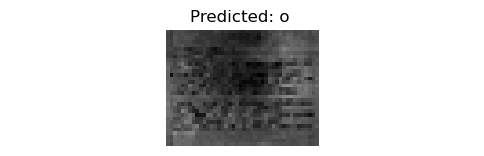

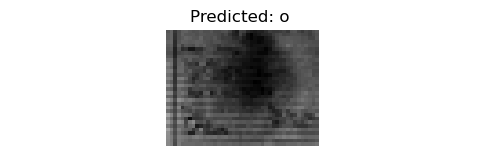

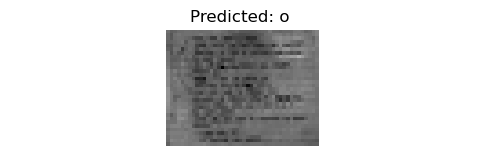

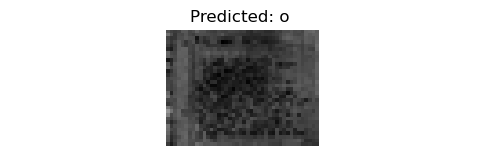

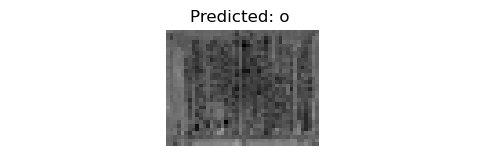

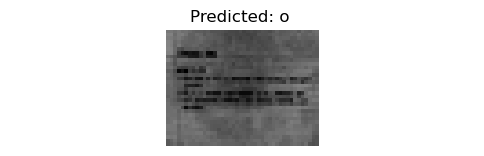

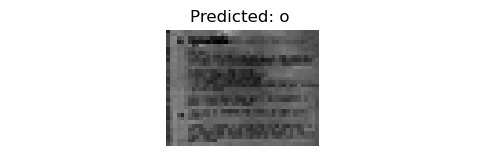

In [4]:
from tensorflow.keras.layers import RandomContrast, RandomZoom
# ────────────── 1) IMPORTS ──────────────
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# ────────────── 2) PARAMETERS ──────────────
IMG_WIDTH, IMG_HEIGHT = 128, 32
MAX_LABEL_LENGTH = 110

import cv2      # ← new, alongside your other imports

def resize_with_padding(img,
                        target_width=IMG_WIDTH,
                        target_height=IMG_HEIGHT,
                        upscale=True):
    # 1) convert to grayscale numpy array
    arr = np.array(img.convert("L"))
    
    # 2) adaptive threshold (Gaussian)
    #    — this binarizes the ink vs. paper
    arr = cv2.adaptiveThreshold(
        arr,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=11,
        C=2
    )
    
    # 3) back to PIL Image so we can reuse your pad/resize logic
    img = Image.fromarray(arr)
    
    # — now the same centering & padding as before —
    old_w, old_h = img.size
    scale = min(target_width/old_w, target_height/old_h)
    if not upscale:
        scale = min(scale, 1.0)
    new_w = int(old_w * scale)
    new_h = int(old_h * scale)
    
    # high-quality resize
    img = img.resize((new_w, new_h), resample=Image.Resampling.LANCZOS)
    
    # create white canvas and paste centered
    canvas = Image.new("L", (target_width, target_height), 255)
    ul = ((target_width-new_w)//2, (target_height-new_h)//2)
    canvas.paste(img, ul)
    
    # normalize and add channel dim
    return np.expand_dims(np.array(canvas, dtype=np.float32)/255.0, axis=-1)



# ────────────── 4) LOAD & PREPROCESS IAM DATA ──────────────
dataset = load_dataset("Teklia/IAM-line")
iam_texts = [ex["text"] for ex in dataset["train"]]

# build char tokenizer
tokenizer = Tokenizer(char_level=True, lower=False, filters="")
tokenizer.fit_on_texts(iam_texts)
M = max(tokenizer.word_index.values())
NUM_CLASSES = M + 1  # blank token at index M

# preprocess IAM images
train_images = np.array([
    resize_with_padding(ex["image"])
    for ex in dataset["train"]
])

# preprocess IAM labels
train_labels = tokenizer.texts_to_sequences(iam_texts)
train_labels = pad_sequences(train_labels, MAX_LABEL_LENGTH, padding="post", value=0)
train_labels = np.where(train_labels != 0, train_labels - 1, 0)  # map to 0..M-1

print("IAM data:", train_images.shape, train_labels.shape)

# ────────────── 5) LOAD & PREPROCESS CUSTOM DATA ──────────────
samples_image_folder = "/Users/shikhusanjel/Desktop/CNNTEST/jpg"
samples_label_file   = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt"  # YOUR PATH HERE

# read labels
with open(samples_label_file, "r", encoding="utf-8") as f:
    custom_labels = [l.strip() for l in f]

# list & sort images
image_paths = sorted([
    os.path.join(samples_image_folder, f)
    for f in os.listdir(samples_image_folder)
    if f.lower().endswith(".jpg")
])
print("Custom count:", len(image_paths), len(custom_labels))

# preprocess custom images + labels
custom_images = np.array([
    resize_with_padding(Image.open(p))
    for p in image_paths
])
custom_seq = tokenizer.texts_to_sequences(custom_labels)
custom_seq = pad_sequences(custom_seq, MAX_LABEL_LENGTH, padding="post", value=0)
custom_seq = np.where(custom_seq != 0, custom_seq - 1, 0)

print("Custom data:", custom_images.shape, custom_seq.shape)

# ────────────── 6) MERGE & SPLIT ──────────────
X = np.concatenate([train_images, custom_images], axis=0)
Y = np.concatenate([train_labels,  custom_seq   ], axis=0)

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)
print("Split:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# ────────── inside your BUILD & COMPILE MODEL block ──────────
input_img    = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name="image_input")
labels_input = layers.Input((MAX_LABEL_LENGTH,), dtype="int32", name="label")

# ↓ new augmentation layers ↓
x = RandomContrast(0.2)(input_img)      # ±20% contrast
x = RandomZoom(0.1, 0.05)(x)            # up to 10% zoom in, 5% zoom out

# now plug x into your Conv2D stack instead of input_img:
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

# CNN + BiLSTM + CTC
x = layers.Conv2D(64, 3, padding="same", activation="relu")(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128,3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Reshape((-1, 128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

def ctc_lambda(args):
    y_pred, labels = args
    # get time dimension, cast to float
    time_steps = tf.cast(tf.shape(y_pred)[1], tf.float32)
    # build input_length as float32
    input_len = tf.ones((tf.shape(y_pred)[0],1), dtype="float32") * time_steps
    # count nonzero labels, cast to float32
    label_len = tf.cast(tf.math.count_nonzero(labels, axis=1, keepdims=True), tf.float32)
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)


loss_out = layers.Lambda(
    ctc_lambda,
    output_shape=(1,),
    name="ctc_loss"
)([y_pred, labels_input])


optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
ctc_model = Model([input_img, labels_input], loss_out)
ctc_model.compile(optimizer=optimizer, loss=lambda y_true,y_pred: y_pred)

# ────────────── 8) TRAIN ──────────────
dummy_train = np.zeros((len(X_train),1))
dummy_val   = np.zeros((len(X_val  ),1))

ctc_model.fit(
    [X_train, y_train], dummy_train,
    validation_data=([X_val, y_val], dummy_val),
    epochs=20, batch_size=32
)

# ────────────── 9) PREDICTION MODEL & DECODER ──────────────
pred_model = Model(input_img, y_pred)

def decode_batch(preds):
    # use beam search
    input_len = np.ones((preds.shape[0],)) * preds.shape[1]
    decoded, log_prob = tf.keras.backend.ctc_decode(
        preds,
        input_length=input_len,
        greedy=False,
        beam_width=10,    # keep top 10 beams
        top_paths=1
    )
    seqs = decoded[0].numpy()
    texts = []
    for seq in seqs:
        s = "".join([ tokenizer.sequences_to_texts([[t+1]])[0] 
                      for t in seq if t >= 0 ])
        texts.append(s)
    return texts


# ────────────── 10) RUN ON YOUR TEST FOLDER ──────────────
test_folder = "/Users/shikhusanjel/Desktop/test"  # YOUR PATH HERE
test_paths  = sorted([os.path.join(test_folder,f)
                      for f in os.listdir(test_folder) if f.endswith(".jpg")])

test_images = np.array([resize_with_padding(Image.open(p)) for p in test_paths])
test_preds  = pred_model.predict(test_images)
decoded     = decode_batch(test_preds)

# visualize
for img, txt in zip(test_images, decoded):
    plt.figure(figsize=(6,2))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Predicted: {txt}")
    plt.axis("off")
    plt.show()



In [22]:
!pip install jiwer --quiet

import os, numpy as np, tensorflow as tf, cv2
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer   # ← move Tokenizer here
import jiwer
import matplotlib.pyplot as plt

# ────────────── 2) PARAMETERS ──────────────
IMG_W, IMG_H = 128, 32
MAX_LABEL_LEN = 110

# ────────────── 3) RESIZE + PAD w/ OTSU ──────────────
def resize_with_padding_otsu(img, target_w=IMG_W, target_h=IMG_H):
    # 1) to gray numpy
    arr = np.array(img.convert("L"))
    # 2) Otsu threshold
    _, arr = cv2.threshold(arr, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 3) back to PIL, resize + center‐pad
    img2 = Image.fromarray(arr)
    ow, oh = img2.size
    scale = min(target_w/ow, target_h/oh)
    nw, nh = int(ow*scale), int(oh*scale)
    img2 = img2.resize((nw, nh), Image.Resampling.LANCZOS)
    canvas = Image.new("L", (target_w, target_h), 255)
    ul = ((target_w-nw)//2, (target_h-nh)//2)
    canvas.paste(img2, ul)
    return np.expand_dims(np.array(canvas)/255.0, -1)

# ────────────── 4) LOAD & PREPROCESS ──────────────
ds = load_dataset("Teklia/IAM-line")
texts = [ex["text"] for ex in ds["train"]]
tok = Tokenizer(char_level=True, lower=False, filters="")
tok.fit_on_texts(texts)
M = max(tok.word_index.values()); NUM_CLASSES = M+1

# IAM images + labels
X_iam = np.stack([resize_with_padding_otsu(ex["image"]) for ex in ds["train"]])
Y_iam = tok.texts_to_sequences(texts)
Y_iam = pad_sequences(Y_iam, MAX_LABEL_LEN, padding="post", value=0)
Y_iam = np.where(Y_iam>0, Y_iam-1, 0)

# CUSTOM
img_folder = "/Users/shikhusanjel/Desktop/CNNTEST/jpg"
lbl_file   = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt"
with open(lbl_file) as f: custom_txt = [l.strip() for l in f]
paths = sorted([os.path.join(img_folder,f) 
                for f in os.listdir(img_folder)
                if f.lower().endswith(".jpg")])
X_cust = np.stack([resize_with_padding_otsu(Image.open(p)) for p in paths])
Y_cust = tok.texts_to_sequences(custom_txt)
Y_cust = pad_sequences(Y_cust, MAX_LABEL_LEN, padding="post", value=0)
Y_cust = np.where(Y_cust>0, Y_cust-1, 0)

# MERGE & SPLIT
X = np.concatenate([X_iam, X_cust], axis=0)
Y = np.concatenate([Y_iam, Y_cust], axis=0)
Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=0.2, random_state=42)
# ────────────── 5) SLIDING-WINDOW CHUNKING ──────────────
# ────────────── SLIDING-WINDOW PATCHING (fixed) ──────────────
WINDOW_W, STRIDE = 64, 32

def make_windows(X, Y, w=WINDOW_W, s=STRIDE):
    """
    Split each image of shape (H, W, C) into overlapping width-w patches,
    stride s, and duplicate its label for each patch.
    """
    X_patches, Y_patches = [], []
    for img, lbl in zip(X, Y):
        H, W, C = img.shape
        # slide along the width dimension
        for start in range(0, W - w + 1, s):
            patch = img[:, start:start + w, :]
            X_patches.append(patch)
            Y_patches.append(lbl)
    # if no patches (shouldn't happen if W>=w), fall back
    if not X_patches:
        return X, Y
    return np.stack(X_patches), np.stack(Y_patches)

# apply to train & val
Xtr, Ytr = make_windows(Xtr, Ytr)
Xva, Yva = make_windows(Xva, Yva)

# override the global width so your model picks up the new patch size
IMG_W = WINDOW_W

print("Windowed train:", Xtr.shape, Ytr.shape)
print("Windowed   val:", Xva.shape, Yva.shape)



# ────────────── 5) BUILD & TRAIN ──────────────
inp_img = layers.Input((IMG_H,IMG_W,1), name="img")
inp_lbl = layers.Input((MAX_LABEL_LEN,), dtype="int32", name="lbl")

# simple CNN→BiLSTM→CTC (no aug here)
x = layers.Conv2D(64,3,padding="same",activation="relu")(inp_img)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Reshape((-1,128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

def ctc_loss(args):
    y_pr, lbl = args
    tsteps = tf.cast(tf.shape(y_pr)[1], tf.float32)
    inp_len = tf.ones((tf.shape(y_pr)[0],1),tf.float32)*tsteps
    lbl_len = tf.cast(tf.math.count_nonzero(lbl,1,keepdims=True),tf.float32)
    return tf.keras.backend.ctc_batch_cost(lbl, y_pr, inp_len, lbl_len)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name="ctc")([y_pred, inp_lbl])
model = Model([inp_img, inp_lbl], loss_out)
model.compile("adam", loss=lambda y_true,y_pred: y_pred)

dummy_tr = np.zeros((len(Xtr),1)); dummy_va = np.zeros((len(Xva),1))
model.fit([Xtr,Ytr], dummy_tr,
          validation_data=([Xva,Yva],dummy_va),
          epochs=20, batch_size=32)

# … your model.fit(…) cell finishes here …

# ────────────── 9) PREDICTION MODEL ──────────────
pred_model = Model(inp_img, y_pred)

# ────────────── 10) BEAM-SEARCH METRICS ──────────────
import jiwer

# 1) Get raw CTC‐output probabilities
va_preds = pred_model.predict(Xva)
input_len = np.ones((va_preds.shape[0],)) * va_preds.shape[1]

# 2) Decode with beam search
decoded_beam, _ = tf.keras.backend.ctc_decode(
    va_preds,
    input_length=input_len,
    greedy=False,
    beam_width=10,
    top_paths=1
)
decoded_beam = decoded_beam[0].numpy()

# 3) Turn sequences back into text
gt_texts = [
    "".join(tok.index_word[c+1] for c in seq if c >= 0)
    for seq in Yva
]
beam_texts = [
    "".join(tok.index_word[c+1] for c in seq if c >= 0)
    for seq in decoded_beam
]

# 4) Compute CER/WER
cer_beam = jiwer.cer(gt_texts, beam_texts)
wer_beam = jiwer.wer(gt_texts, beam_texts)
print(f"Beam CER: {cer_beam:.3f}, Beam WER: {wer_beam:.3f}")


Windowed train: (15708, 32, 64, 1) (15708, 110)
Windowed   val: (3927, 32, 64, 1) (3927, 110)
Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 97s 196ms/step - loss: 133.3281 - val_loss: 113.1148
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 107s 217ms/step - loss: 111.2896 - val_loss: 106.6294
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 107s 218ms/step - loss: 105.3012 - val_loss: 105.2302
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 106s 217ms/step - loss: 103.8944 - val_loss: 104.6224
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 107s 218ms/step - loss: 103.0082 - val_loss: 104.3101
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 107s 218ms/step - loss: 103.6388 - val_loss: 104.0894
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 1261s 3s/step - loss: 102.7539 - val_loss: 104.0355
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 104s 213ms/step - loss: 102.7719 - val_loss: 103.7221
Epoch 9/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 105s 214ms/step - loss: 102.4431 - val_loss: 103.5785
Epoch 10/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 105s 214ms/step - loss

In [ ]:
!pip install jiwer --quiet

import os, numpy as np, tensorflow as tf, cv2
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer   # ← move Tokenizer here
import jiwer
import matplotlib.pyplot as plt

# ────────────── 2) PARAMETERS ──────────────
IMG_W, IMG_H = 128, 32
MAX_LABEL_LEN = 110

# ────────────── 3) RESIZE + PAD w/ OTSU ──────────────
def resize_with_padding_otsu(img, target_w=IMG_W, target_h=IMG_H):
    # 1) to gray numpy
    arr = np.array(img.convert("L"))
    # 2) Otsu threshold
    _, arr = cv2.threshold(arr, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 3) back to PIL, resize + center‐pad
    img2 = Image.fromarray(arr)
    ow, oh = img2.size
    scale = min(target_w/ow, target_h/oh)
    nw, nh = int(ow*scale), int(oh*scale)
    img2 = img2.resize((nw, nh), Image.Resampling.LANCZOS)
    canvas = Image.new("L", (target_w, target_h), 255)
    ul = ((target_w-nw)//2, (target_h-nh)//2)
    canvas.paste(img2, ul)
    return np.expand_dims(np.array(canvas)/255.0, -1)

# ────────────── 4) LOAD & PREPROCESS ──────────────
ds = load_dataset("Teklia/IAM-line")
texts = [ex["text"] for ex in ds["train"]]
tok = Tokenizer(char_level=True, lower=False, filters="")
tok.fit_on_texts(texts)
M = max(tok.word_index.values()); NUM_CLASSES = M+1

# IAM images + labels
X_iam = np.stack([resize_with_padding_otsu(ex["image"]) for ex in ds["train"]])
Y_iam = tok.texts_to_sequences(texts)
Y_iam = pad_sequences(Y_iam, MAX_LABEL_LEN, padding="post", value=0)
Y_iam = np.where(Y_iam>0, Y_iam-1, 0)

# CUSTOM
img_folder = "/Users/shikhusanjel/Desktop/CNNTEST/jpg"
lbl_file   = "/Users/shikhusanjel/Desktop/CNNTEST/SamplePassage.txt"
with open(lbl_file) as f: custom_txt = [l.strip() for l in f]
paths = sorted([os.path.join(img_folder,f) 
                for f in os.listdir(img_folder)
                if f.lower().endswith(".jpg")])
X_cust = np.stack([resize_with_padding_otsu(Image.open(p)) for p in paths])
Y_cust = tok.texts_to_sequences(custom_txt)
Y_cust = pad_sequences(Y_cust, MAX_LABEL_LEN, padding="post", value=0)
Y_cust = np.where(Y_cust>0, Y_cust-1, 0)

# MERGE & SPLIT
X = np.concatenate([X_iam, X_cust], axis=0)
Y = np.concatenate([Y_iam, Y_cust], axis=0)
Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=0.2, random_state=42)
# ────────────── 5) SLIDING-WINDOW CHUNKING ──────────────
# ────────────── SLIDING-WINDOW PATCHING (fixed) ──────────────
WINDOW_W, STRIDE = 64, 32

def make_windows(X, Y, w=WINDOW_W, s=STRIDE):
    """
    Split each image of shape (H, W, C) into overlapping width-w patches,
    stride s, and duplicate its label for each patch.
    """
    X_patches, Y_patches = [], []
    for img, lbl in zip(X, Y):
        H, W, C = img.shape
        # slide along the width dimension
        for start in range(0, W - w + 1, s):
            patch = img[:, start:start + w, :]
            X_patches.append(patch)
            Y_patches.append(lbl)
    # if no patches (shouldn't happen if W>=w), fall back
    if not X_patches:
        return X, Y
    return np.stack(X_patches), np.stack(Y_patches)

# apply to train & val
Xtr, Ytr = make_windows(Xtr, Ytr)
Xva, Yva = make_windows(Xva, Yva)

# override the global width so your model picks up the new patch size
IMG_W = WINDOW_W

print("Windowed train:", Xtr.shape, Ytr.shape)
print("Windowed   val:", Xva.shape, Yva.shape)



# ────────────── 5) BUILD & TRAIN ──────────────
inp_img = layers.Input((IMG_H,IMG_W,1), name="img")
inp_lbl = layers.Input((MAX_LABEL_LEN,), dtype="int32", name="lbl")

# simple CNN→BiLSTM→CTC (no aug here)
x = layers.Conv2D(64,3,padding="same",activation="relu")(inp_img)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Reshape((-1,128))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

def ctc_loss(args):
    y_pr, lbl = args
    tsteps = tf.cast(tf.shape(y_pr)[1], tf.float32)
    inp_len = tf.ones((tf.shape(y_pr)[0],1),tf.float32)*tsteps
    lbl_len = tf.cast(tf.math.count_nonzero(lbl,1,keepdims=True),tf.float32)
    return tf.keras.backend.ctc_batch_cost(lbl, y_pr, inp_len, lbl_len)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name="ctc")([y_pred, inp_lbl])
model = Model([inp_img, inp_lbl], loss_out)
model.compile("adam", loss=lambda y_true,y_pred: y_pred)

dummy_tr = np.zeros((len(Xtr),1)); dummy_va = np.zeros((len(Xva),1))
model.fit([Xtr,Ytr], dummy_tr,
          validation_data=([Xva,Yva],dummy_va),
          epochs=20, batch_size=32)

# … your model.fit(…) cell finishes here …

# ────────────── 9) PREDICTION MODEL ──────────────
pred_model = Model(inp_img, y_pred)

# ────────────── 10) BEAM-SEARCH METRICS ──────────────
import jiwer

# 1) Get raw CTC‐output probabilities
va_preds = pred_model.predict(Xva)
input_len = np.ones((va_preds.shape[0],)) * va_preds.shape[1]

# 2) Decode with beam search
decoded_beam, _ = tf.keras.backend.ctc_decode(
    va_preds,
    input_length=input_len,
    greedy=False,
    beam_width=10,
    top_paths=1
)
decoded_beam = decoded_beam[0].numpy()

# 3) Turn sequences back into text
gt_texts = [
    "".join(tok.index_word[c+1] for c in seq if c >= 0)
    for seq in Yva
]
beam_texts = [
    "".join(tok.index_word[c+1] for c in seq if c >= 0)
    for seq in decoded_beam
]

# 4) Compute CER/WER
cer_beam = jiwer.cer(gt_texts, beam_texts)
wer_beam = jiwer.wer(gt_texts, beam_texts)
print(f"Beam CER: {cer_beam:.3f}, Beam WER: {wer_beam:.3f}")


Sorted images: ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test8.jpg', 'test9.jpg', 'test10.jpg', 'test11.jpg', 'test12.jpg', 'test13.jpg', 'test14.jpg', 'test15.jpg', 'test16.jpg', 'test17.jpg', 'test18.jpg', 'test19.jpg', 'test20.jpg', 'test21.jpg', 'test22.jpg', 'test23.jpg', 'test24.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Easy‐sample CER: 1.766, WER: 3.800


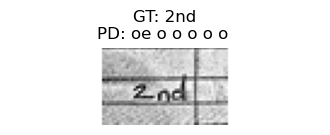

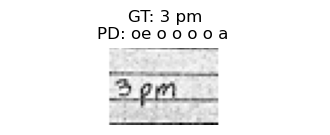

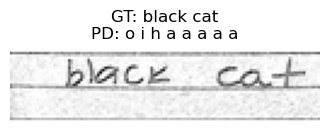

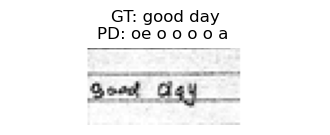

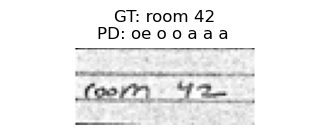

In [62]:
# ────────────── EVALUATE ON EASY SAMPLES ──────────────
!pip install jiwer --quiet

import os, re
import numpy as np
import tensorflow as tf
from jiwer import cer, wer
import matplotlib.pyplot as plt
from PIL import Image

# 1) Folders & files — update these paths to your desktop
easy_folder = "/Users/shikhusanjel/Desktop/easytest"
gt_file     = "/Users/shikhusanjel/Desktop/easytest.txt"

# 2) Collect & sort images by the number in their filename
easy_paths = [
    os.path.join(easy_folder, fn)
    for fn in os.listdir(easy_folder)
    if fn.lower().endswith(".jpg")
]
easy_paths.sort(key=lambda p: int(re.search(r"(\d+)", os.path.basename(p)).group(1)))
print("Sorted images:", [os.path.basename(p) for p in easy_paths])

# 3) Load GT labels
with open(gt_file, "r", encoding="utf-8") as f:
    gt_texts = [l.strip() for l in f]
assert len(gt_texts) == len(easy_paths),\
       f"Found {len(easy_paths)} images but {len(gt_texts)} labels!"

# 4) Load & preprocess the images
easy_imgs = np.stack([resize_with_padding(Image.open(p)) for p in easy_paths])

# 5) Run your trained model
easy_preds = pred_model.predict(easy_imgs)

# 6) Beam-search CTC decode
input_len = np.ones((len(easy_preds),), dtype=np.int32) * easy_preds.shape[1]
decoded_idxs, _ = tf.keras.backend.ctc_decode(
    easy_preds,
    input_length=input_len,
    greedy=False,
    beam_width=10,
    top_paths=1
)
decoded_seq = decoded_idxs[0].numpy()  # (batch, time_steps)

# 7) Map to text
pd_texts = [
    "".join(tok.index_word.get(c+1, "") for c in seq if c >= 0)
    for seq in decoded_seq
]

# 8) Compute CER & WER
print(f"Easy‐sample CER: {cer(gt_texts, pd_texts):.3f}, WER: {wer(gt_texts, pd_texts):.3f}")

# 9) Visualize a handful
for img, gt, pd in zip(easy_imgs[:5], gt_texts[:5], pd_texts[:5]):
    plt.figure(figsize=(4,2))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"GT: {gt}\nPD: {pd}")
    plt.axis("off")
    plt.show()
